In [410]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

### Read data

In [411]:
# Read data
uncertainty = pd.read_csv('../data/processed/uncertainty_index.csv')
ip = pd.read_csv('../data/processed/ip.csv', encoding='unicode_escape')

# Merge
data = pd.merge(uncertainty,ip,on='period')

# Set 'period' as the index
data.set_index('period', inplace=True)

# Create a new column 'y_diff' representing the difference (lagged by 1 period) of ip
data['ip_diff'] = data['ip'].diff()
data.dropna(inplace=True)


In [412]:
data.head()

,uncertainty,ip,ip_diff
period,,,
2000M08,0.415137,17.0097,0.2966
2000M09,0.311315,17.2867,0.2770
2000M10,0.491417,17.4958,0.2091
2000M11,0.460621,17.8917,0.3959
2000M12,0.003944,18.2370,0.3453


### STNSU & IP

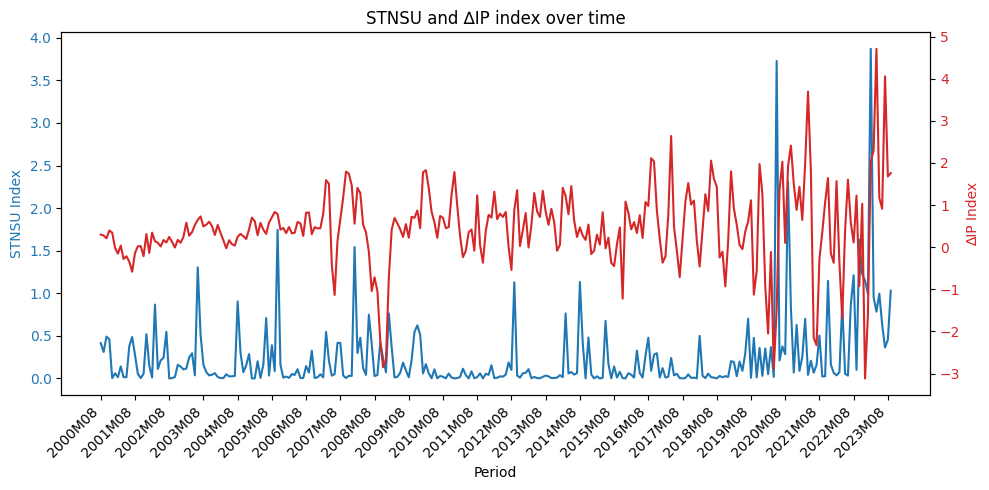

In [413]:

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the first time series on the left y-axis (ax1)
color = 'tab:blue'
ax1.set_xlabel('Period')
ax1.set_ylabel('STNSU Index', color=color)
ax1.plot(data.index, data['uncertainty'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis (ax2) on the right
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('∆IP Index', color=color)
ax2.plot(data.index, data['ip_diff'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Set x-axis ticks at intervals of 12 periods and rotate x-labels
ax1.set_xticks(data.index[::12])
ax1.set_xticklabels(data.index[::12], rotation=45, ha='right')

# Show the plot
plt.title('STNSU and ∆IP index over time')
plt.tight_layout() 
plt.show()


### Model


In [414]:
# Set target and feature data
Y = data['ip_diff']
X = data['uncertainty']


In [415]:
def lag_list(Y, X, p=1, q=0):

    ADLx = pd.DataFrame()
    T = len(Y)
    ADLy = list(Y[max(p, q):T])
    for i in range(1, p+1):
        name = f'y_{i}'
        ADLx[name] = list(Y[max(p, q)-i:T-i])
    for i in range(1, q+1):
        name = f'x_{i}'
        ADLx[name] = list(X[max(p, q)-i:T-i])
        
    return ADLy, ADLx
    

In [416]:

# Define a function to fit the ADL model and calculate AIC
def fit_adl_model(Y, X, p, q):
    ADLy, ADLx = lag_list(Y, X, p, q)
    ADLx = sm.add_constant(ADLx)
    model = sm.OLS(ADLy, ADLx)
    results = model.fit()
    return results, results.aic

# Grid search for lag orders
best_aic = float('inf')
best_p, best_q = 0, 0

for p in range(1, 10 + 1):
    for q in range(0, 10 + 1):
        _, aic = fit_adl_model(Y, X, p, q)
        if aic < best_aic:
            best_aic = aic
            best_p, best_q = p, q

print("Best AIC:", best_aic)
print("Best p, q:", best_p, best_q)


Best AIC: 665.2687607041016
Best p, q: 5 9


In [417]:
# Model 1
ADLy1, ADLx1 = lag_list(Y, X, p=4, q=10)
ADLx1 = sm.add_constant(ADLx1)
mod1 = sm.OLS(ADLy1, ADLx1)
res1 = mod1.fit()

print("Summary for Model:")
print(res1.summary())

Summary for Model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     9.011
Date:                Mon, 15 Jan 2024   Prob (F-statistic):           5.97e-16
Time:                        06:37:45   Log-Likelihood:                -317.88
No. Observations:                 268   AIC:                             665.8
Df Residuals:                     253   BIC:                             719.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2051      0.079 

In [420]:
# Model 2
ADLy2, ADLx2 = lag_list(Y, X, p=4, q=0)
ADLx2 = sm.add_constant(ADLx2)
mod2 = sm.OLS(ADLy2, ADLx2)
res2 = mod2.fit()

print("Summary for Model:")
print(res2.summary())

Summary for Model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     23.37
Date:                Mon, 15 Jan 2024   Prob (F-statistic):           1.35e-16
Time:                        06:39:05   Log-Likelihood:                -337.52
No. Observations:                 274   AIC:                             685.0
Df Residuals:                     269   BIC:                             703.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2691      0.062 

In [421]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming you have test data and true values 'y_true'

# Get model predictions on the test data
y_pred_model1 = res1.predict(ADLx1)
y_pred_model2 = res2.predict(ADLx2)

# # Assuming 'period' is the name of the index in Y and y_pred_model1
# Set the index of y_pred_model1 to match the index of Y
y_pred_model1.index = Y.index[10:]  # Exclude the first element due to lag
error_model1 = Y[10:] - y_pred_model1  # Exclude the first element due to lag

y_pred_model2.index = Y.index[4:]
error_model2 = Y[4:] - y_pred_model2


# Calculate squared differences between forecast errors
squared_diff = (error_model1 - error_model2)**2

# Calculate mean squared differences
mean_squared_diff = np.mean(squared_diff)

# Calculate standard error of the mean squared differences
n = len(Y)
se_squared_diff = np.sqrt((1/n) * mean_squared_diff)

# Calculate standard errors for DM statistic
variance_dm = (2 * (mean_squared_diff**2)) / (n - 1)
se_dm_statistic = np.sqrt(variance_dm)

# Calculate DM statistic
dm_statistic = mean_squared_diff / se_squared_diff

# Print DM statistic and its standard error
print("DM Statistic (Model 1 vs Model 2):", dm_statistic)
print("Standard Error of DM Statistic:", se_dm_statistic)


DM Statistic (Model 1 vs Model 2): 4.49426391280046
Standard Error of DM Statistic: 0.006173727557609882
